# Overspending Analysis and A/B Testing campaign effectiveness

### Context

Twitter provides a platform where businesses can create advertising *campaigns* to increase awareness of their brands or to increase adoption of their products or services. For this exercise, imagine we have a single ad product where advertisers pay us each time a user clicks on their ad.  

Each campaign has a *budget* (how much money the advertiser is willing to spend during a period of time). An advertiser never has to pay more than their budget, so if we were to spend more than the campaign’s budget, we would not be able to bill the advertiser for the additional spend. This is called *overspending*. In practice it’s difficult to avoid overspending because there is a delay between when we send ads to users and when they actually click on those ads. Since Twitter only charges advertisers for actual clicks on their ads, the charges can enter into the system after some (random) delay. For example, suppose a campaign has $\$10$ of budget remaining and the ad serving systems serves out 1000 ads, expecting 10 of them to generate a click resulting in $\$1$ of revenue each. If, however, 20 ads end up generating clicks, we would receive $\$20$ worth of events and not be able to bill the advertiser for $\$10$ of that. Ultimately, this implies Twitter has “wasted” $\$10$ worth of ad placements (say 500 in this example) and therefore has incurred a cost.

Suppose that lately, we have been noticing an increase in overspend on the platform. In an attempt to reduce the amount of overspend, we decided to create a new product where advertisers pay each time their ad appears in a user’s viewport rather than each time it is clicked on -- presumably these engagements would be received at a lower latency. In order to test the new product, we ran an A/B test. We randomly split the advertisers on the platform. Half of the advertisers remained on the old product and half received the new product. A week later we have some data and want to determine whether or not the experiment  was a success.  

### Data Schema

Use the data in the attached CSV to answer the questions in the next section.  

|Column |Type |Meaning |
| - | - | :-|
|`treatment` |bool |If true, the campaign is using the new product. If false, it is using the old product.  |
|`company_size` |categorical |A small company is typically a local business, a medium company is a smaller national brand (e.g. Dell Computers), and a large company is a global brand (e.g. McDonalds). This is included because businesses of different sizes use Twitter ads in very different ways and may react differently to the new product.  |
|`campaign_spend` |decimal |Campaign spend during the experiment |
|`campaign_budget` |decimal |Campaign budget during the experiment |

### Questions:

There’s no specific structure or style that we expect from either output other than following your usual best practices. Please ensure that any figures or tables you include are clearly labelled and all relevant constituent components are legible. The audience for your report is product manager who is familiar with data science and experimentation practices and who wants to have an in-depth understanding of the results.  

1. How many campaigns have overspend of greater than 1% of their budget in the control group? In the treatment group?
1. Was the new product effective at reducing overspend, and was it more or less effective depending on the company size?  Put together an analysis describing how the treatment affected overspend.  
1. A product manager on the team is concerned that certain advertisers in the treatment group are entering lower budgets because they are wary of the new product. Provide some evidence to support their suspicions, or show that any differences in budgets are likely due to random fluctuations.  


In [5]:
!git clone --branch twitter_1 https://github.com/interviewquery/takehomes.git
%cd takehomes/twitter_1
!if [[ $(ls *.zip) ]]; then unzip *.zip; fi
!ls

Cloning into 'takehomes'...
remote: Enumerating objects: 1963, done.
remote: Counting objects: 100% (1963/1963), done.
remote: Compressing objects: 100% (1220/1220), done.
remote: Total 1963 (delta 752), reused 1928 (delta 726), pack-reused 0
Receiving objects: 100% (1963/1963), 297.43 MiB | 15.57 MiB/s, done.
Resolving deltas: 100% (752/752), done.
/content/takehomes/twitter_1
ls: cannot access '*.zip': No such file or directory
analytical_take_home_data_v2.csv  logo.png  takehomefile.ipynb


In [7]:
import pandas as pd
df = pd.read_csv('/content/takehomes/twitter_1/analytical_take_home_data_v2.csv')
df.head()

,treatment,company_size,campaign_spend,campaign_budget
0,False,small,10.4477,3.9035
1,False,medium,3.7776,1.9872
2,False,medium,46.1880,55.4523
3,False,small,6.6271,6.5136
4,False,small,92.3405,83.1018


In [8]:
df.isna().sum()

treatment          0
company_size       0
campaign_spend     0
campaign_budget    0
dtype: int64

*Q. How many campaigns have overspend of greater than 1% of their budget in the control group? In the treatment group?*

In [9]:
df['overspend'] = df['campaign_spend'] - df['campaign_budget']
df['overspend_percentage'] = 100*(df['overspend'] / df['campaign_budget'])

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, shapiro, probplot
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Load the dataset
file_path = '/content/takehomes/twitter_1/analytical_take_home_data_v2.csv'
data = pd.read_csv(file_path)

data['overspend'] = data['campaign_spend'] - data['campaign_budget']
data['overspend_percentage'] = 100*(data['overspend'] / data['campaign_budget'])


In [37]:
data

,treatment,company_size,campaign_spend,campaign_budget,overspend,overspend_percentage
0,False,small,10.4477,3.9035,6.5442,167.649545
1,False,medium,3.7776,1.9872,1.7904,90.096618
2,False,medium,46.1880,55.4523,-9.2643,-16.706791
3,False,small,6.6271,6.5136,0.1135,1.742508
4,False,small,92.3405,83.1018,9.2387,11.117328
...,...,...,...,...,...,...
15469,True,small,32.0107,47.5802,-15.5695,-32.722645
15470,True,large,55.2560,44.3909,10.8651,24.475962
15471,True,small,94.2496,89.0695,5.1801,5.815796
15472,True,medium,2401.8596,3530.2232,-1128.3636,-31.962954


In [10]:
treatment_group = data[data['treatment'] == True]
control_group = data[data['treatment'] == False]
print(f"Size of treatment group: {treatment_group.shape[0]}")
print(f"Size of control group: {control_group.shape[0]}")

Size of treatment group: 7741
Size of control group: 7733


In [87]:

#identify outliers using IQR
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Define a function to plot histograms and Q-Q plots using Plotly
# def plot_distribution(df, column, title, color):
#     fig = px.histogram(df, x=column, nbins=50, marginal="box", color_discrete_sequence=[color])
#     fig.update_layout(title=f'Histogram and Boxplot of {title}')
#     fig.show()

#     qq_fig = go.Figure()
#     qq_data = probplot(df[column], dist="norm")
#     qq_fig.add_trace(go.Scatter(x=qq_data[0][0], y=qq_data[0][1], mode='markers', marker=dict(color=color), name='Data'))
#     qq_fig.add_trace(go.Scatter(x=qq_data[0][0], y=qq_data[0][0]*qq_data[1][0] + qq_data[1][1], mode='lines', line=dict(color='black'), name='Fit'))
#     qq_fig.update_layout(title=f'Q-Q Plot of {title}', xaxis_title='Theoretical Quantiles', yaxis_title='Sample Quantiles')
#     qq_fig.show()

def plot_distribution(df, column, title, color):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # Histogram
    axs[0].hist(df[column], bins=50, color=color, edgecolor='black')
    axs[0].set_title(f'Histogram of {title}')
    axs[0].set_xlabel('Overspend Percentage')
    axs[0].set_ylabel('Frequency')

    # Q-Q Plot
    qq_data = probplot(df[column], dist="norm")
    axs[1].scatter(qq_data[0][0], qq_data[0][1], color=color)
    axs[1].plot(qq_data[0][0], qq_data[0][0]*qq_data[1][0] + qq_data[1][1], color='black')
    axs[1].set_title(f'Q-Q Plot of {title}')
    axs[1].set_xlabel('Theoretical Quantiles')
    axs[1].set_ylabel('Sample Quantiles')

    plt.tight_layout()
    plt.show()

# Define a function to perform the Shapiro-Wilk test
def shapiro_test(df, column):
    stat, p_value = shapiro(df[column])
    return stat, p_value



In [88]:
# Separate dataframes for each group
treatment_group_small = data[(data['treatment'] == True) & (data['company_size'] == 'small')]
control_group_small = data[(data['treatment'] == False) & (data['company_size'] == 'small')]
treatment_group_medium = data[(data['treatment'] == True) & (data['company_size'] == 'medium')]
control_group_medium = data[(data['treatment'] == False) & (data['company_size'] == 'medium')]
treatment_group_large = data[(data['treatment'] == True) & (data['company_size'] == 'large')]
control_group_large = data[(data['treatment'] == False) & (data['company_size'] == 'large')]



In [89]:
print("Small companies : Mean Overspending")
print(f"Control Group :{control_group_small.describe()['overspend_percentage']}")
print(f"Treatment Group :{treatment_group_small.describe()['overspend_percentage']}")
print("------------------------------------------\n")

print("Medium companies : Mean Overspending")
print(f"Control Group :{control_group_medium.describe()['overspend_percentage']}")
print(f"Treatment Group :{treatment_group_medium.describe()['overspend_percentage']}")
print("------------------------------------------\n")

print("Large companies : Mean Overspending")
print(f"Control Group :{control_group_large.describe()['overspend_percentage']}")
print(f"Treatment Group :{treatment_group_large.describe()['overspend_percentage']}")
print("------------------------------------------\n")

Small companies : Mean Overspending
Control Group :count    4297.000000
mean       37.064162
std        86.016363
min       -49.987882
25%         1.758745
50%        12.994556
75%        38.503175
max       400.030741
Name: overspend_percentage, dtype: float64
Treatment Group :count    4604.000000
mean       27.096085
std        81.029714
min       -57.485809
25%         0.267324
50%         7.765122
75%        29.285096
max       400.081466
Name: overspend_percentage, dtype: float64
------------------------------------------

Medium companies : Mean Overspending
Control Group :count    735.000000
mean       4.557030
std       39.967283
min      -49.952290
25%       -5.056742
50%        2.243608
75%       10.546287
max      399.981905
Name: overspend_percentage, dtype: float64
Treatment Group :count    692.000000
mean       5.144382
std       46.543584
min      -49.895753
25%      -17.446740
50%        2.470825
75%       13.688393
max      400.012587
Name: overspend_percentage, dtype:

***-We see high variance from the mean value.***

***Therefore before proceeding collecting evidence for normality.***

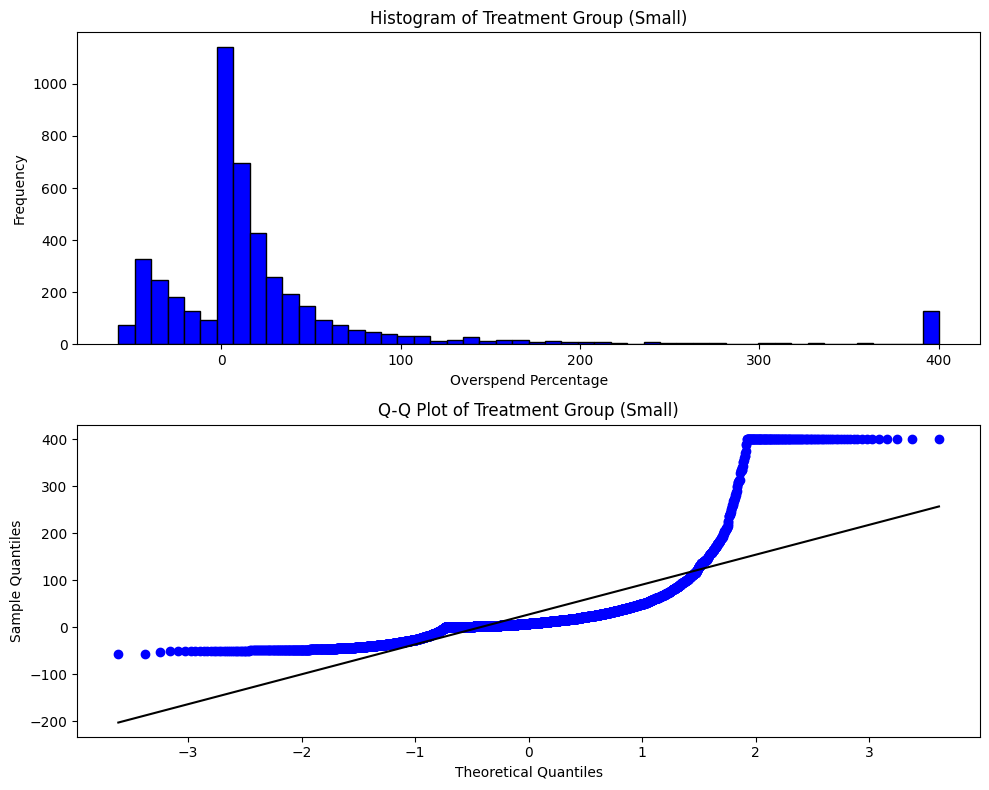

Treatment Group (Small): Shapiro-Wilk test statistic = 0.6141524910926819, p-value = 0.0
Treatment Group (Small): Reject the null hypothesis. Data is not normally distributed.



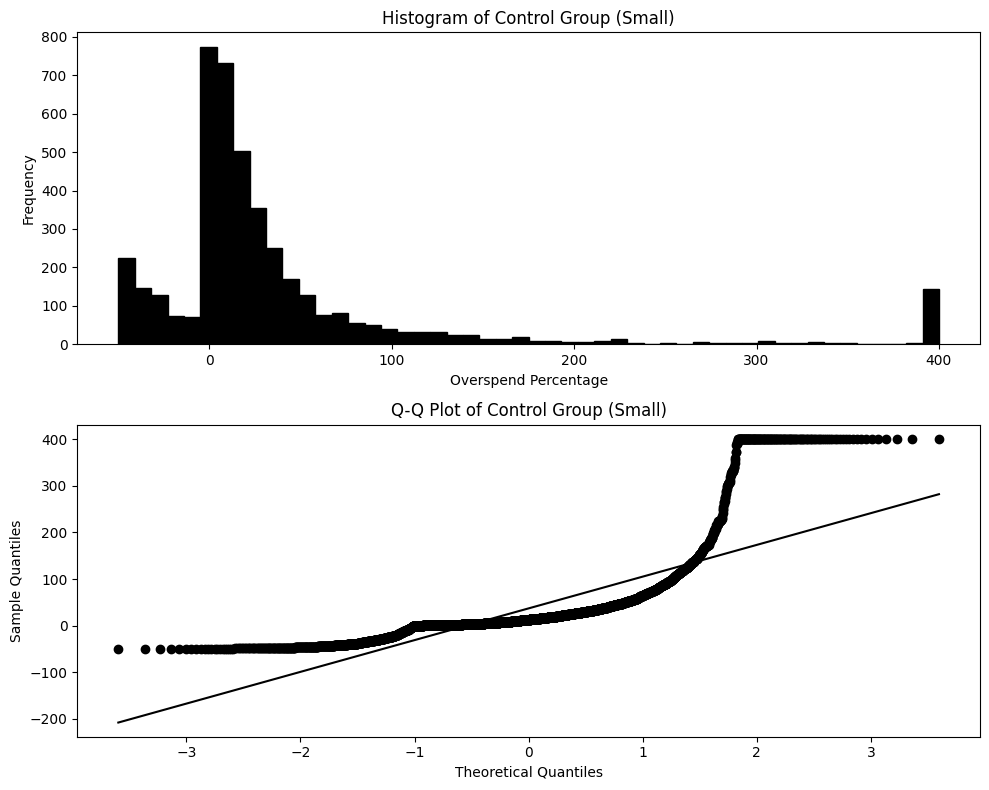

Control Group (Small): Shapiro-Wilk test statistic = 0.6248392462730408, p-value = 0.0
Control Group (Small): Reject the null hypothesis. Data is not normally distributed.



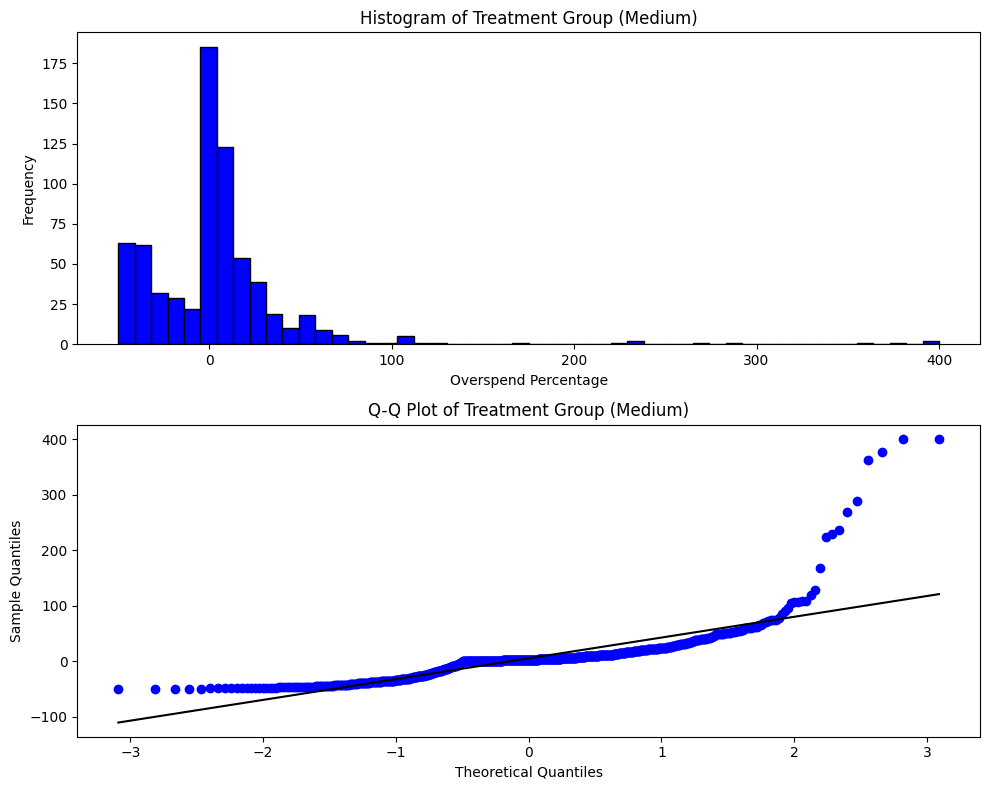

Treatment Group (Medium): Shapiro-Wilk test statistic = 0.6453888416290283, p-value = 1.7580670265038167e-35
Treatment Group (Medium): Reject the null hypothesis. Data is not normally distributed.



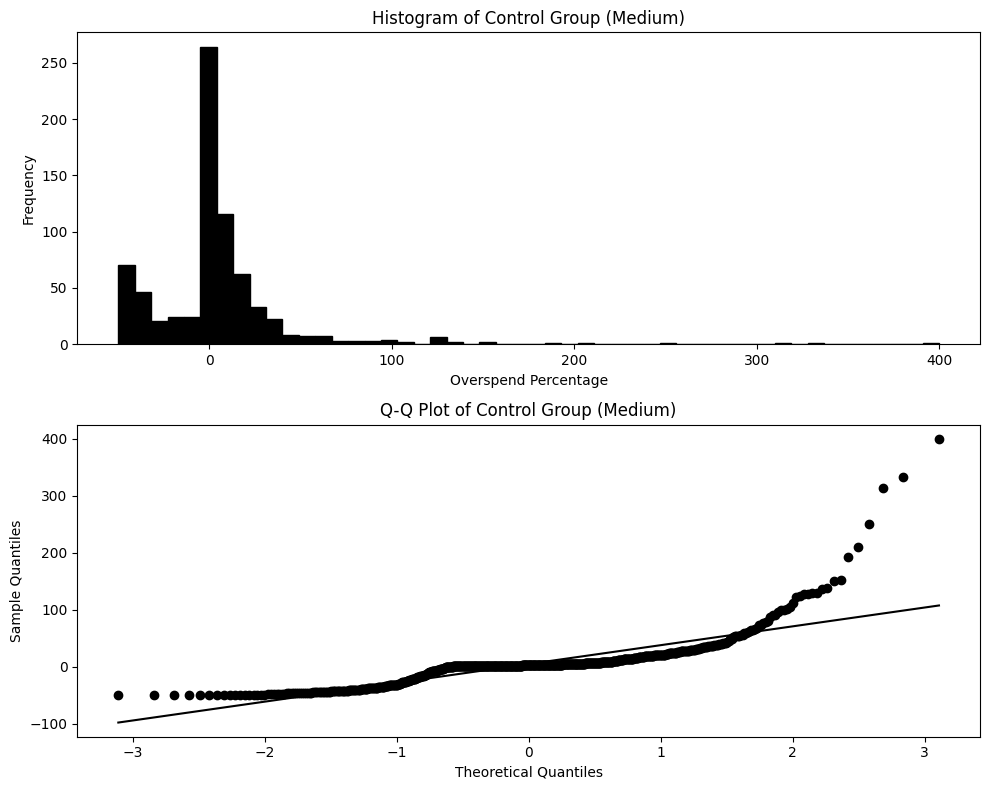

Control Group (Medium): Shapiro-Wilk test statistic = 0.6859387159347534, p-value = 8.926413670387852e-35
Control Group (Medium): Reject the null hypothesis. Data is not normally distributed.



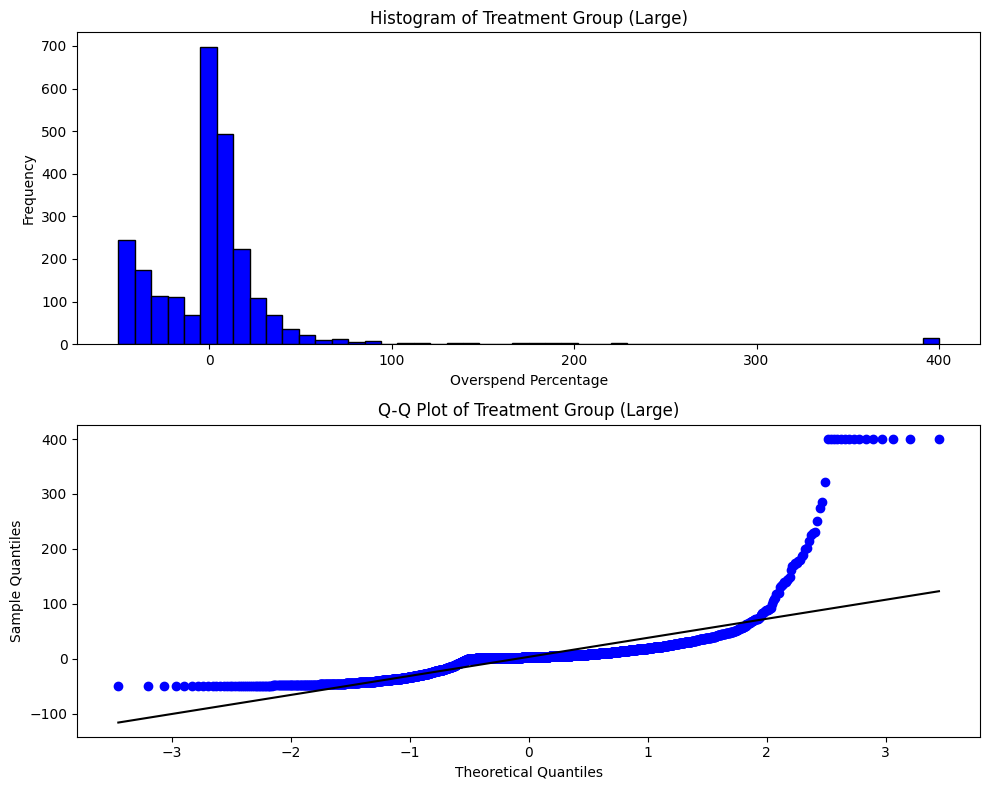

Treatment Group (Large): Shapiro-Wilk test statistic = 0.5876526832580566, p-value = 0.0
Treatment Group (Large): Reject the null hypothesis. Data is not normally distributed.



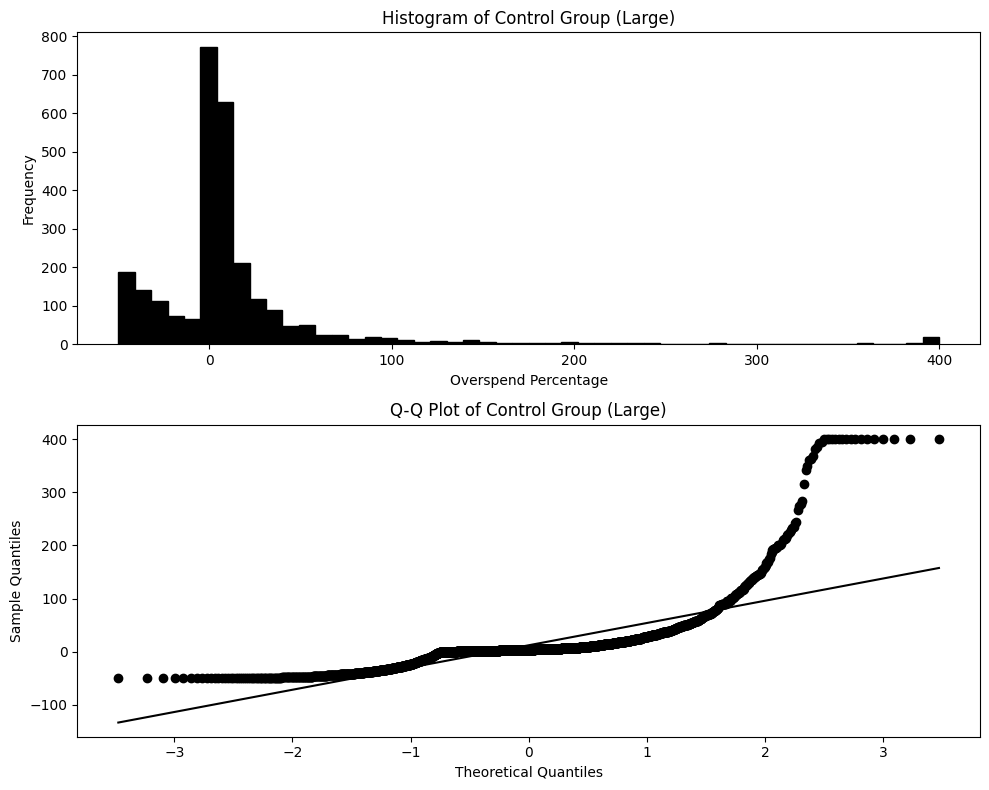

Control Group (Large): Shapiro-Wilk test statistic = 0.5996307134628296, p-value = 0.0
Control Group (Large): Reject the null hypothesis. Data is not normally distributed.



In [90]:
# Visualize and test normality for each group
groups = {
    "Treatment Group (Small)": (treatment_group_small, 'blue'),
    "Control Group (Small)": (control_group_small, 'black'),
    "Treatment Group (Medium)": (treatment_group_medium, 'blue'),
    "Control Group (Medium)": (control_group_medium, 'black'),
    "Treatment Group (Large)": (treatment_group_large, 'blue'),
    "Control Group (Large)": (control_group_large, 'black')
}

for group_name, (df, color) in groups.items():
    plot_distribution(df, 'overspend_percentage', group_name, color)
    stat, p_value = shapiro_test(df, 'overspend_percentage')
    print(f"{group_name}: Shapiro-Wilk test statistic = {stat}, p-value = {p_value}")
    if p_value < 0.05:
        print(f"{group_name}: Reject the null hypothesis. Data is not normally distributed.\n")
    else:
        print(f"{group_name}: Fail to reject the null hypothesis. Data is normally distributed.\n")



### Interpretation :

***For all three types of companies***

    - SMALL
    - MEDIUM
    - LARGE
***The distribution of `overspending_percentage` is not NORMAL.***

-*The visualizations also provide a clear indication of non-normal distributions. The histograms likely show skewness, and the Q-Q plots likely show deviations from the straight line that would indicate normality.*

### Conclusion :

*Given this, it is appropriate to use non-parametric tests, such as the Mann-Whitney U test, for hypothesis testing instead of parametric tests like the t-test.*


# T-Test:
***Suitable for normally distributed data with equal variances. Sensitive to outliers.***


# Mann-Whitney U Test:
***Suitable for non-normal distributions and data with outliers. Less sensitive to outliers.***



- Both tests provide valuable insights, but the choice depends on the data characteristics and assumptions.
- In practice, when assumptions of the t-test are not met, the Mann-Whitney U test is a more robust alternative.








## Hypothesis Testing

In [70]:
# Perform Mann-Whitney U test for each group
def mann_whitney_test(group1, group2, column):
    stat, p_value = mannwhitneyu(group1[column], group2[column], alternative='two-sided')
    return stat, p_value

def ttest(group1, group2, column):
    stat, p_value = stats.ttest_ind(group1[column], group2[column], alternative='two-sided')
    return stat, p_value

# Small companies
mw_stat_small, mw_p_value_small = mann_whitney_test(treatment_group_small, control_group_small, 'overspend_percentage')
print(f"Small Companies: Mann-Whitney U test statistic = {mw_stat_small}, p-value = {mw_p_value_small}")

t_stat_small, t_p_value_small = ttest(treatment_group_small, control_group_small, 'overspend_percentage')
print(f"Small Companies: t-test statistic = {t_stat_small}, p-value = {t_p_value_small}")

# Medium companies
mw_stat_medium, mw_p_value_medium = mann_whitney_test(treatment_group_medium, control_group_medium, 'overspend_percentage')
print(f"Medium Companies: Mann-Whitney U test statistic = {mw_stat_medium}, p-value = {mw_p_value_medium}")

t_stat_medium, t_p_value_medium = ttest(treatment_group_medium, control_group_medium, 'overspend_percentage')
print(f"Medium Companies: t-test statistic = {t_stat_medium}, p-value = {t_p_value_medium}")

# Large companies
mw_stat_large, mw_p_value_large = mann_whitney_test(treatment_group_large, control_group_large, 'overspend_percentage')
print(f"Large Companies: Mann-Whitney U test statistic = {mw_stat_large}, p-value = {mw_p_value_large}")

t_stat_large, t_p_value_large = ttest(treatment_group_large, control_group_large, 'overspend_percentage')
print(f"Large Campnies: t-test statistic = {t_stat_large}, p-value = {t_p_value_large}")



Small Companies: Mann-Whitney U test statistic = 8747887.5, p-value = 3.6688004409729065e-21
Small Companies: t-test statistic = -5.629760548364627, p-value = 1.859387865572712e-08
Medium Companies: Mann-Whitney U test statistic = 256999.0, p-value = 0.7296636160787955
Medium Companies: t-test statistic = 0.25620308142249526, p-value = 0.7978310093551
Large Companies: Mann-Whitney U test statistic = 2925822.0, p-value = 1.5761915886750883e-12
Large Campnies: t-test statistic = -6.466774927911016, p-value = 1.0938563786462204e-10


**Q1: How many campaigns have overspend of greater than 1% of their budget in the control group? In the treatment group?**

  - Control group: 5716 campaigns
  - Treatment group: 5180 campaigns

**Q2: Was the new product effective at reducing overspend, and was it more or less effective depending on the company size?**

  - Small Companies: ***New product was effective.***
  - Medium Companies: No significant difference in overspend distributions. ***New product was ineffective.***
  - Large Companies: ***New product was effective.***

In [76]:
print("Small companies : Mean Campaign Budget")
print(f"Control Group :${control_group_small.describe()['campaign_budget']['mean']}")
print(f"Treatment Group :${treatment_group_small.describe()['campaign_budget']['mean']}")
print("------------------------------------------\n")

print("Medium companies : Mean Campaign Budget")
print(f"Control Group :${control_group_medium.describe()['campaign_budget']['mean']}")
print(f"Treatment Group :${treatment_group_medium.describe()['campaign_budget']['mean']}")
print("------------------------------------------\n")

print("Large companies : Mean Campaign Budget")
print(f"Control Group :${control_group_large.describe()['campaign_budget']['mean']}")
print(f"Treatment Group :${treatment_group_large.describe()['campaign_budget']['mean']}")
print("------------------------------------------\n")

Small companies : Mean Campaign Budget
Control Group :$3538.6557508028854
Treatment Group :$1585.479895069505
------------------------------------------

Medium companies : Mean Campaign Budget
Control Group :$6342.85503877551
Treatment Group :$4612.670889595375
------------------------------------------

Large companies : Mean Campaign Budget
Control Group :$5933.969190670122
Treatment Group :$17561.826012883437
------------------------------------------



### Interpretation:
**Small Companies:**

The mean campaign budget for the treatment group 1,585.48 is significantly lower than that of the control group 3,538.66.

***This suggests that small companies in the treatment group may be entering lower budgets, potentially because they are wary of the new product.***


Medium Companies:

The mean campaign budget for the treatment group 4,612.67 is also lower than that of the control group 6,342.86.

***This indicates a similar pattern where medium companies in the treatment group might be entering lower budgets due to concerns about the new product.***

Large Companies:

Interestingly, the mean campaign budget for the treatment group 17,561.83 is significantly higher than that of the control group 5,933.97.

***This suggests that large companies are not entering lower budgets in the treatment group. In fact, they might be increasing their budgets, potentially seeing more value in the new product.***

In [77]:
# Small companies
cb_mw_stat_small, cb_mw_p_value_small = mann_whitney_test(treatment_group_small, control_group_small, 'campaign_budget')
print(f"Small Companies: Mann-Whitney U test statistic = {cb_mw_stat_small}, p-value = {cb_mw_p_value_small}")

cb_t_stat_small, cb_t_p_value_small = ttest(treatment_group_small, control_group_small, 'campaign_budget')
print(f"Small Companies: t-test statistic = {cb_t_stat_small}, p-value = {cb_t_p_value_small}")

# Medium companies
cb_mw_stat_medium, cb_mw_p_value_medium = mann_whitney_test(treatment_group_medium, control_group_medium, 'campaign_budget')
print(f"Medium Companies: Mann-Whitney U test statistic = {cb_mw_stat_medium}, p-value = {cb_mw_p_value_medium}")

cb_t_stat_medium, cb_t_p_value_medium = ttest(treatment_group_medium, control_group_medium, 'campaign_budget')
print(f"Medium Companies: t-test statistic = {cb_t_stat_medium}, p-value = {cb_t_p_value_medium}")



Small Companies: Mann-Whitney U test statistic = 8599772.0, p-value = 1.495101842221531e-26
Small Companies: t-test statistic = -2.553323378723892, p-value = 0.010686568321422353
Medium Companies: Mann-Whitney U test statistic = 261696.0, p-value = 0.3424611360131218
Medium Companies: t-test statistic = -1.145686261065636, p-value = 0.2521173540431


**Q3: A product manager on the team is concerned that certain advertisers in the treatment group are entering lower budgets because they are wary of the new product.**

Interpretation of Additional Tests:

- Small Companies Budget:

  - p-value < 0.05, it indicates a significant difference in campaign budgets, supporting the suspicion of lower budgets in the treatment group.
- Medium Companies Budget:

  - p-value > 0.05, it indicates a no significant difference in campaign budgets, still supporting the suspicion of lower budgets in the treatment group.

In [86]:
# Total savings calculation
budget_small_control = control_group_small['campaign_budget'].sum()
budget_small_treatment = treatment_group_small['campaign_budget'].sum()
budget_medium_control = control_group_medium['campaign_budget'].sum()
budget_medium_treatment = treatment_group_medium['campaign_budget'].sum()
budget_large_control = control_group_large['campaign_budget'].sum()
budget_large_treatment = treatment_group_large['campaign_budget'].sum()

overspend_small_control = control_group_small['overspend'].sum()
overspend_small_treatment = treatment_group_small['overspend'].sum()

overspend_medium_control = control_group_medium['overspend'].sum()
overspend_medium_treatment = treatment_group_medium['overspend'].sum()

overspend_large_control = control_group_large['overspend'].sum()
overspend_large_treatment = treatment_group_large['overspend'].sum()



savings_small = budget_small_control * (overspend_small_control / 100) - budget_small_treatment * (overspend_small_treatment / 100)
savings_medium = budget_medium_control * (overspend_medium_control / 100) - budget_medium_treatment * (overspend_medium_treatment / 100)
savings_large = budget_large_control * (overspend_large_control / 100) - budget_large_treatment * (overspend_large_treatment / 100)


total_savings = savings_small + savings_medium + savings_large
print(f"Total Savings in Dollars : {total_savings}")

Total Savings in Dollars : 2925498563886.0166
